# Validation against Lueders et al. 2004

This notebook compares metaSIPSim simulation results against those of Lueders et al. 2004. Comparisons are made to figure 1A from said paper.

For the simulation, I will be generating fragments only. I will estimate the amount of DNA from each genome in each fraction by multiplying fragment size by simulated abundance then summing within each genome.

Lueders, T., Manefield, M. and Friedrich, M. W. (2004), Enhanced sensitivity of DNA- and rRNA-based stable isotope probing by fractionation and quantitative analysis of isopycnic centrifugation gradients. Environmental Microbiology, 6: 73–78. doi:10.1046/j.1462-2920.2003.00536.x

## Intitiation

In [1]:
import os
import pandas as pd
import ConfigParser
import rpy2.ipython

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(ggplot2)

/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [4]:
# What is your working directory?
workdir = '/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/'

# Where are your genomes?
genomedir = '/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/genomes/'



In [5]:
# making directories
## working directory
if not os.path.isdir(workdir):
    os.makedirs(workdir)
%cd $workdir

## genome directory
if not os.path.isdir(genomedir):
    os.makedirs(genomedir)
print(genomedir)

/home/sam/data/SIPSim2_data/dev/validation/Lueders2004
/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/genomes/


## Part 1: Get genomes

In [6]:
%cd $genomedir
# The genomes you want are:
## Methanosarcina barkeri MS: GCA_000970025.1
## Methylobacterium extorquens AM1: GCF_000022685.1

!wget -O Methanosarcina_barkeri_MS.fna.gz ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/970/025/GCF_000970025.1_ASM97002v1/GCF_000970025.1_ASM97002v1_genomic.fna.gz

!wget -O Methylobacterium_extorquens_AM1.fna.gz ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/022/685/GCF_000022685.1_ASM2268v1/GCF_000022685.1_ASM2268v1_genomic.fna.gz
    
!gunzip Methanosarcina_barkeri_MS.fna.gz
!gunzip Methylobacterium_extorquens_AM1.fna.gz

/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/genomes
--2019-05-22 13:08:20--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/970/025/GCF_000970025.1_ASM97002v1/GCF_000970025.1_ASM97002v1_genomic.fna.gz
           => ‘Methanosarcina_barkeri_MS.fna.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 2607:f220:41e:250::11
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCF/000/970/025/GCF_000970025.1_ASM97002v1 ... done.
==> SIZE GCF_000970025.1_ASM97002v1_genomic.fna.gz ... 1340774
==> PASV ... done.    ==> RETR GCF_000970025.1_ASM97002v1_genomic.fna.gz ... done.
Length: 1340774 (1.3M) (unauthoritative)

GCF_000970025.1_ASM 100%[===================>]   1.28M  --.-KB/s    in 0.1s    

2019-05-22 13:08:21 (9.91 MB/s) - ‘Methanosarcina_barkeri_MS.fna.gz’ saved [1340774]

--2019-05-22 13:08:21--

## Part 2: Simulation

### A) Get genome indexes

In [7]:
%cd $workdir

/home/sam/data/SIPSim2_data/dev/validation/Lueders2004


In [8]:
# make index file of genomes 
!ls $genomedir | grep ".fna" > genome_files.txt
!tail genome_files.txt

Methanosarcina_barkeri_MS.fna
Methylobacterium_extorquens_AM1.fna


In [9]:
with open("genome_files.txt", 'r') as genome_files, open ("genome_index.txt", 'w') as genome_index:
    genomes = genome_files.readlines()
    for line in genomes:
        fasta = line
        taxa = fasta.replace('.fna\n', '\t')
        genome_index.write(taxa + fasta)
!cat genome_index.txt

Methanosarcina_barkeri_MS	Methanosarcina_barkeri_MS.fna
Methylobacterium_extorquens_AM1	Methylobacterium_extorquens_AM1.fna


### B) Set up experimental design

#### List of incorporators
Only Methylobacterium extorquens AM1 is an incorporator in this experiment and it was grown almost completely with 13C so it will be 100% labeled.

In [10]:
library = [2]

taxon_name = ['Methylobacterium_extorquens_AM1'] 

percent_incorporation = [100.0]

sd_incorporation = [0]

incorporators = pd.DataFrame({'taxon_name':taxon_name, 'library':library, 
                       'percent_incorporation':percent_incorporation, 'sd_incorporation':sd_incorporation})
incorporators = incorporators.reindex(columns = ['taxon_name', 'library', 'percent_incorporation', 'sd_incorporation'])
incorporators.to_csv("incorporators.txt", sep='\t', index=False)

!cat incorporators.txt

taxon_name	library	percent_incorporation	sd_incorporation
Methylobacterium_extorquens_AM1	2	100.0	0


#### Community composition file
Cultures were grown in isolate so abundance is 100%

In [11]:
library = [1, 2]

taxon_name = ['Methanosarcina_barkeri_MS', 'Methylobacterium_extorquens_AM1'] 

rel_abund_perc = [100.0, 100.0]

rank = [1,1]

comm = pd.DataFrame({'library':library, 'taxon_name':taxon_name, 
                       'rel_abund_perc':rel_abund_perc, 'rank':rank})
comm = comm.reindex(columns = ['library', 'taxon_name', 'rel_abund_perc', 'rank'])
comm.to_csv("comm.txt", sep='\t', index=False)

!cat comm.txt

library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
2	Methylobacterium_extorquens_AM1	100.0	1


#### Generate fraction file
Here I will use estimated fractions based on the fractions used in the paper.

In [12]:
%%R
lueders_data = read.table('/home/sam/data/SIPSim2_data/dev/validation/figure_estimates.txt', 
                          header=TRUE, sep="\t") %>%
    filter(Study == "Lueders2004") %>%
    mutate(BD = round(BD, digits=3))
fractions = lueders_data %>%
    select(library, BD, fraction) %>%
    group_by(library) %>%
    mutate(last_frac = max(fraction)) %>%
    ungroup()
for (i in 1:nrow(fractions)){
    fractions$BD_prev[i] = fractions$BD[i-1]
    fractions$BD_next[i] = fractions$BD[i+1]
    if (fractions$fraction[i] == 1){
        fractions$BD_prev[i] = (2*fractions$BD[i])-fractions$BD_next[i]
    }
    if (fractions$fraction[i] == fractions$last_frac[i]){
        fractions$BD_next[i] = (2*fractions$BD[i])-fractions$BD_prev[i]
    }
}
fractions = fractions %>%
    mutate(BD_min = (BD+BD_prev)/2, BD_max = (BD+BD_next)/2) %>%
    mutate(fraction_size = round(BD_max-BD_min, 4)) %>%
    select(library, fraction, BD_min, BD_max, fraction_size)
write.table(fractions, "fracs.txt", quote=F, sep="\t", row.names=F)

In [13]:
!cat fracs.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.679	1.685	0.006
1	2	1.685	1.69	0.005
1	3	1.69	1.6945	0.0045
1	4	1.6945	1.7	0.0055
1	5	1.7	1.706	0.006
1	6	1.706	1.712	0.006
1	7	1.712	1.7185	0.0065
1	8	1.7185	1.7255	0.007
1	9	1.7255	1.732	0.0065
1	10	1.732	1.7385	0.0065
1	11	1.7385	1.744	0.0055
1	12	1.744	1.7475	0.0035
1	13	1.7475	1.7505	0.003
2	1	1.6815	1.6865	0.005
2	2	1.6865	1.692	0.0055
2	3	1.692	1.698	0.006
2	4	1.698	1.705	0.007
2	5	1.705	1.713	0.008
2	6	1.713	1.7205	0.0075
2	7	1.7205	1.7285	0.008
2	8	1.7285	1.7375	0.009
2	9	1.7375	1.7465	0.009
2	10	1.7465	1.754	0.0075
2	11	1.754	1.761	0.007
2	12	1.761	1.768	0.007
2	13	1.768	1.774	0.006


### C) Make configuration file for simulation
This configuration file contains all the information needed for simulation. Gradient parameters are the same as those in the paper.

In [14]:
config = ConfigParser.SafeConfigParser()

## Other parameters
config.add_section('Other')
config.set('Other', 'temp_directory', './tmp')
config.set('Other', 'threads', '1')
config.set('Other', 'logfile', 'SIPSim2_Lueders.log')
config.set('Other', 'endpoint', 'fragment_list')

## Library parameters
config.add_section('Library')
config.set('Library', 'library_list', '1, 2')
config.set('Library', 'window_or_fraction', 'fraction')

## Fragment parameters
config.add_section('Fragment')
config.set('Fragment', 'genome_index_file', 'genome_index.txt')
config.set('Fragment', 'genomeDir', genomedir)
config.set('Fragment', 'frag_length_distribution', 'skewed-normal,9000,2500,-5')
config.set('Fragment', 'coverage_of_fragments', '100')
config.set('Fragment', 'fragment_file', 'frags.txt')
config.set('Fragment', 'temp_fragment_file', 'tmp.frags')
config.set('Fragment', 'number_of_iterations', '1')


## Gradient parameters
config.add_section('Gradient')
config.set('Gradient', 'temperature', '293.15')
config.set('Gradient', 'avg_density', '1.725')
config.set('Gradient', 'angular_velocity', '20465612')
config.set('Gradient', 'min_rotation_radius', '7.21')
config.set('Gradient', 'max_rotation_radius', '8.49')
config.set('Gradient', 'tube_angle', '0')
config.set('Gradient', 'tube_radius', '0.65')
config.set('Gradient', 'tube_height', '6.6')
config.set('Gradient', 'fraction_frag_in_DBL', '0.001')
config.set('Gradient', 'isotope', 'C')

## Model parameters
config.add_section('Model')
config.set('Model', 'min_bouyant_density', '1.67')
config.set('Model', 'max_bouyant_density', '1.775')
config.set('Model', 'bouyant_density_step', '0.0001')
config.set('Model', 'fraction_table_file', 'fracs.txt')

## Community parameters
config.add_section('Community')
config.set('Community', 'community_file', 'comm.txt')
config.set('Community', 'incorporator_file', 'incorporators.txt')

## Sequencing parameters
config.add_section('Sequencing')
config.set('Sequencing', 'number_of_genomes_per_iteration', '1')


# Writing our configuration file to 'example.cfg'
with open('simulation_parameters.cfg', 'wb') as configfile:
    config.write(configfile)

### D) Simulate fragments for each fraction
Use the function SIPSim2_get_fragment_list_fractions.py to get the fragments for each genome in each fraction of every library

In [15]:
!python /home/sam/notebooks/SIPSim_metagenome/bin/SIPSim_metagenome.py simulation_parameters.cfg

Running SIPSim_metagenome
This program was writen by Samuel Barnett (seb369@cornell.edu)

This run was started on 22/05/19 at 13:08:50


You have chosen to get an list of simulated SIP metagenome fragments with adjusted buoyant densities.
You have selected to simulate metagenome sequences for each fraction.

Your community abundance file is: comm.txt

Your incorporator assignment file is: incorporators.txt

You are simulating with the isotope of C

It took 0.764 seconds to get these models.
It took 0.749 seconds to get these models.

Building fragments

It took 58.718 seconds to build the fragments

----------

Starting library 1

Starting library 1 fraction 1 BD:1.679-1.685
Writing fragments to file
It took 25.154 seconds to write fragment file.
It took 25.154 seconds to run library 1 fraction BD:1.679-1.685 iteration 1

It took 25.154 seconds to run the library 1 fraction 1 BD:1.679-1.685

Starting library 1 fraction 2 BD:1.685-1.69
Writing fragments to file
It took 25.03 seconds to 

## Part 3: Original SIPSim simulation

To see how well SIPSim does compared to previous simululation methods, I'll run the same analysis using SIPSim

In [16]:
%cd $workdir

/home/sam/data/SIPSim2_data/dev/validation/Lueders2004


Modify the comm.txt file so that you include both genomes

In [17]:
%%bash
echo -e "library\ttaxon_name\trel_abund_perc\trank" > comm2.txt
echo -e "1\tMethanosarcina_barkeri_MS\t100.0\t1\n1\tMethylobacterium_extorquens_AM1\t0.0\t2" >> comm2.txt
echo -e "2\tMethylobacterium_extorquens_AM1\t100.0\t1\n2\tMethanosarcina_barkeri_MS\t0.0\t2" >> comm2.txt

cat comm2.txt

library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
1	Methylobacterium_extorquens_AM1	0.0	2
2	Methylobacterium_extorquens_AM1	100.0	1
2	Methanosarcina_barkeri_MS	0.0	2


### 1) Get fragments

In [18]:
!SIPSim fragments \
    genome_index.txt \
    --fp $genomedir/ \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 100X \
    --tbl \
    --np 20 \
    2> Leuders_SIPsim.log \
    > Leuders_SIPsim.txt
!cat Leuders_SIPsim.log

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
Processing: "Methanosarcina_barkeri_MS"
Processing: "Methylobacterium_extorquens_AM1"
  Genome name: Methanosarcina_barkeri_MS
  Genome length (bp): 4574907
  Number of amplicons: None
  Number of fragments simulated: 64859
  Genome name: Methylobacterium_extorquens_AM1
  Genome length (bp): 6879778
  Number of amplicons: None
  Number of fragments simulated: 97821


### 2) Convert to 2d-KDE format

In [19]:
!SIPSim fragment_KDE \
    Leuders_SIPsim.txt \
    > Leuders_SIPsim_kde.pkl
    
!ls -thlc Leuders_SIPsim_kde.pkl

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
-rw-rw-r-- 1 sam sam 2.5M May 22 13:26 Leuders_SIPsim_kde.pkl


### 3) Add diffusion

In [20]:
!SIPSim diffusion \
    Leuders_SIPsim_kde.pkl \
    --np 20 \
    > Leuders_SIPsim_kde_dif.pkl

!ls -thlc Leuders_SIPsim_kde_dif.pkl

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
Index size: 90508
Processing: Methanosarcina_barkeri_MS
Processing: Methylobacterium_extorquens_AM1
-rw-rw-r-- 1 sam sam 7.7M May 22 13:26 Leuders_SIPsim_kde_dif.pkl


### 4) Add diffusive boundery layer

In [21]:
!SIPSim DBL \
    Leuders_SIPsim_kde_dif.pkl \
    --np 20 \
    -D 1.725 \
    -w 20465612 \
    --tube_height 6.6 \
    --r_min 7.21 \
    --r_max 8.49 \
    --vertical \
    > Leuders_SIPsim_kde_dif_DBL.pkl

!ls -thlc Leuders_SIPsim_kde_dif_DBL.pkl

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
DBL_index file written: "DBL_index.txt"
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
-rw-rw-r-- 1 sam sam 7.7M May 22 13:28 Leuders_SIPsim_kde_dif_DBL.pkl


### 5) Add isotope incorporation

In [22]:
!cat incorporators.txt

taxon_name	library	percent_incorporation	sd_incorporation
Methylobacterium_extorquens_AM1	2	100.0	0


In [23]:
%%bash
SIPSim incorp_config_example \
  --percTaxa 100 \
  --percIncorpMean 100 \
  --percIncorpSD 0 \
  --n_reps 1 \
  > incorp.config
  
cat incorp.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
        
        [[[end]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
[2]
    # 'treatment' community: possible incorporation
    treatment = labeled
    max_perc_taxa_incorp = 100
    
    [[intraPopDist 1]]
        distribution = normal
        [[[mu]]]
            [[[[interPopDist 1]]]]
                start = 100
                distribution = uniform
                end = 100
        [[[sigma]]]
            [[[[interPopDist 1]]]]
                start = 0
                distribution = uniform
                end = 0
    


DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2


Make file identifying incorporators for each library

In [24]:
%%bash
echo -e "1\n2\tMethylobacterium_extorquens_AM1\n" > incorp_taxa.txt

cat incorp_taxa.txt


1
2	Methylobacterium_extorquens_AM1



Add isoptope incorporation

In [25]:
!SIPSim isotope_incorp \
    --comm comm2.txt \
    --taxa incorp_taxa.txt \
    --np 20 \
    Leuders_SIPsim_kde_dif_DBL.pkl \
    incorp.config \
    > Leuders_SIPsim_kde_dif_DBL_inc.pkl

!ls -thlc Leuders_SIPsim_kde_dif_DBL_inc.pkl 
!cat BD-shift_stats.txt

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
Loading KDE object...
Processing library: 1
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing library: 2
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
File written: BD-shift_stats.txt
-rw-rw-r-- 1 sam sam 16M May 22 13:28 Leuders_SIPsim_kde_dif_DBL_inc.pkl
library	taxon	min	q25	mean	median	q75	max
1	Methanosarcina_barkeri_MS	0.0	0.0	0.0	0.0	0.0	0.0
1	Methylobacterium_extorquens_AM1	0.0	0.0	0.0	0.0	0.0	0.0
2	Methanosarcina_barkeri_MS	0.0	0.0	0.0	0.0	0.0	0.0
2	Methylobacterium_extorquens_AM1	0.036	0.036	0.036	0.036	0.036	0.036


### 6) Making OTU table


Get fraction table for each library

In [26]:
!head fracs.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.679	1.685	0.006
1	2	1.685	1.69	0.005
1	3	1.69	1.6945	0.0045
1	4	1.6945	1.7	0.0055
1	5	1.7	1.706	0.006
1	6	1.706	1.712	0.006
1	7	1.712	1.7185	0.0065
1	8	1.7185	1.7255	0.007
1	9	1.7255	1.732	0.0065


In [27]:
!SIPSim OTU_table \
    --np 1 \
    --abs 1e5 \
    Leuders_SIPsim_kde_dif_DBL_inc.pkl \
    comm2.txt \
    fracs.txt \
    > Leuders_SIPsim_OTU.txt
    
!head Leuders_SIPsim_OTU.txt

DEBUG:CACHEDIR=/home/sam/.cache/matplotlib
DEBUG:Using fontManager instance from /home/sam/.cache/matplotlib/fontList.json
DEBUG:backend agg version v2.2
Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  100000
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  0
Processing library: "2"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  0
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  100000
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Methanosarcina_barkeri_MS	-inf-1.679	-inf	1.678	1.678	35	1
1	Methanosarcina_barkeri_MS	1.679-1.685	1.679	1.682	1.685	72	1
1	Methanosarcina_barkeri_MS	1.685-1.690	1.685	1.688	1.69	1368	1
1	Methanosarcina_barkeri_MS	1.690-1.694	1.69	1.692	1.694	13200	1
1	Methanosarcina_barkeri_MS	1.694-1.700	1.694	1.697	1.7	51602	1
1	Methanosarcina_barkeri_MS	1.700-1.706	1.7	1.703	1.706	31082	1

## Part 3: Analysis

Now I'll see how well the simulation results correspond with the actual DNA distribution. Here we will also make easier to handle files for nice visualizationg in R.

### Get Lueders data

Also make a dataframe that indicates teh isotope for each reference in each library. This gives a bit more metadata that you can use when plotting

In [28]:
%%R
real.df = read.table('/home/sam/data/SIPSim2_data/dev/validation/figure_estimates.txt', 
                          header=TRUE, sep="\t") %>%
    filter(Study == "Lueders2004") %>%
    mutate(BD = round(BD, digits=3), data_type = "empirical") %>%
    select(taxon_name, Isotope, library, BD, Ratio_of_maximum, data_type, Study)

real.df

                        taxon_name Isotope library    BD Ratio_of_maximum
1        Methanosarcina_barkeri_MS     12C       1 1.682          0.03585
2        Methanosarcina_barkeri_MS     12C       1 1.688          0.18698
3        Methanosarcina_barkeri_MS     12C       1 1.692          1.00000
4        Methanosarcina_barkeri_MS     12C       1 1.697          0.18357
5        Methanosarcina_barkeri_MS     12C       1 1.703          0.02716
6        Methanosarcina_barkeri_MS     12C       1 1.709          0.01958
7        Methanosarcina_barkeri_MS     12C       1 1.715          0.01993
8        Methanosarcina_barkeri_MS     12C       1 1.722          0.02037
9        Methanosarcina_barkeri_MS     12C       1 1.729          0.02077
10       Methanosarcina_barkeri_MS     12C       1 1.735          0.04892
11       Methanosarcina_barkeri_MS     12C       1 1.742          0.04336
12       Methanosarcina_barkeri_MS     12C       1 1.746          0.01783
13       Methanosarcina_barkeri_MS    

In [29]:
%%R
metadata = real.df %>%
    select(taxon_name, Isotope, library, Study) %>%
    unique
metadata

                        taxon_name Isotope library       Study
1        Methanosarcina_barkeri_MS     12C       1 Lueders2004
14 Methylobacterium_extorquens_AM1     13C       2 Lueders2004


### metaSIPSim data
Get the metaSIPSim simulated data and estimate the concentration of DNA from each reference as a ratio to the maximum concentration.

In [30]:
frag_table = pd.DataFrame(columns=['taxon_name', 'library', 'OriBD', 
                                   'percent_incorp', 'abundance',
                                   'fragment_start', 'fragment_length'])
for file in os.listdir(workdir):
    if file.endswith('fragments.txt.gz'):
        fraction = file.split('_')[3]
        frag_table_sub = pd.read_table(file, compression='gzip')
        frag_table_sub['fraction'] = fraction
        frag_table = frag_table.append(frag_table_sub, ignore_index=True)
        
frag_table.to_csv('allfragments.txt', sep='\t', index=False)
frag_table = None

In [31]:
%%R
frag.df = read.delim('allfragments.txt') %>%
    filter(abundance > 0)

head(frag.df)

     OriBD    abundance fraction fragment_length fragment_start library
1 1.695711  0.002016384        3            7544              0       1
2 1.698524  0.002048100        3            3859           7545       1
3 1.698893  0.002052348        3            9119          11405       1
4 1.700138  0.002066889        3            8421          20525       1
5 1.699618  0.002060781        3            6617          28947       1
6 1.693546 99.901992863        3            8469          35565       1
  percent_incorp                                               scaffoldID
1              0 NZ_CP009528.1 Methanosarcina barkeri MS, complete genome
2              0 NZ_CP009528.1 Methanosarcina barkeri MS, complete genome
3              0 NZ_CP009528.1 Methanosarcina barkeri MS, complete genome
4              0 NZ_CP009528.1 Methanosarcina barkeri MS, complete genome
5              0 NZ_CP009528.1 Methanosarcina barkeri MS, complete genome
6              0 NZ_CP009528.1 Methanosarcina barker

In [32]:
%%R
taxa.df = frag.df %>%
    mutate(base_abundance = abundance*fragment_length) %>%
    group_by(taxon_name, fraction, library) %>%
    summarize(DNA_abundance = sum(base_abundance)) %>%
    as.data.frame
frag.df = NULL
taxa.df

                        taxon_name fraction library DNA_abundance
1        Methanosarcina_barkeri_MS        1       1  1.403653e+06
2        Methanosarcina_barkeri_MS        2       1  7.034192e+07
3        Methanosarcina_barkeri_MS        3       1  3.212829e+09
4        Methanosarcina_barkeri_MS        4       1  3.047490e+10
5        Methanosarcina_barkeri_MS        5       1  1.174993e+10
6        Methanosarcina_barkeri_MS        6       1  1.942552e+08
7        Methanosarcina_barkeri_MS        7       1  1.386433e+06
8        Methanosarcina_barkeri_MS        8       1  1.456826e+06
9        Methanosarcina_barkeri_MS        9       1  1.352767e+06
10       Methanosarcina_barkeri_MS       10       1  1.352767e+06
11       Methanosarcina_barkeri_MS       11       1  1.144649e+06
12       Methanosarcina_barkeri_MS       12       1  7.284131e+05
13       Methanosarcina_barkeri_MS       13       1  6.243541e+05
14 Methylobacterium_extorquens_AM1        1       2  2.619457e+06
15 Methylo

In [33]:
%%R
fracs.df = read.delim('fracs.txt') %>%
    mutate(BD = (BD_min + BD_max)/2) %>%
    select(library, fraction, BD)
taxa.df = inner_join(taxa.df, fracs.df)
taxa.df

/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("fraction", "library")

  warnings.warn(x, RRuntimeWarning)


                        taxon_name fraction library DNA_abundance      BD
1        Methanosarcina_barkeri_MS        1       1  1.403653e+06 1.68200
2        Methanosarcina_barkeri_MS        2       1  7.034192e+07 1.68750
3        Methanosarcina_barkeri_MS        3       1  3.212829e+09 1.69225
4        Methanosarcina_barkeri_MS        4       1  3.047490e+10 1.69725
5        Methanosarcina_barkeri_MS        5       1  1.174993e+10 1.70300
6        Methanosarcina_barkeri_MS        6       1  1.942552e+08 1.70900
7        Methanosarcina_barkeri_MS        7       1  1.386433e+06 1.71525
8        Methanosarcina_barkeri_MS        8       1  1.456826e+06 1.72200
9        Methanosarcina_barkeri_MS        9       1  1.352767e+06 1.72875
10       Methanosarcina_barkeri_MS       10       1  1.352767e+06 1.73525
11       Methanosarcina_barkeri_MS       11       1  1.144649e+06 1.74125
12       Methanosarcina_barkeri_MS       12       1  7.284131e+05 1.74575
13       Methanosarcina_barkeri_MS    

In [34]:
%%R
max.abds = taxa.df %>%
    group_by(library, taxon_name) %>%
    summarize(max_DNA = max(DNA_abundance)) %>%
    as.data.frame

taxa.df = inner_join(taxa.df, max.abds) %>%
    mutate(Ratio_of_maximum = DNA_abundance/max_DNA)
taxa.df

/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("taxon_name", "library")

  warnings.warn(x, RRuntimeWarning)


                        taxon_name fraction library DNA_abundance      BD
1        Methanosarcina_barkeri_MS        1       1  1.403653e+06 1.68200
2        Methanosarcina_barkeri_MS        2       1  7.034192e+07 1.68750
3        Methanosarcina_barkeri_MS        3       1  3.212829e+09 1.69225
4        Methanosarcina_barkeri_MS        4       1  3.047490e+10 1.69725
5        Methanosarcina_barkeri_MS        5       1  1.174993e+10 1.70300
6        Methanosarcina_barkeri_MS        6       1  1.942552e+08 1.70900
7        Methanosarcina_barkeri_MS        7       1  1.386433e+06 1.71525
8        Methanosarcina_barkeri_MS        8       1  1.456826e+06 1.72200
9        Methanosarcina_barkeri_MS        9       1  1.352767e+06 1.72875
10       Methanosarcina_barkeri_MS       10       1  1.352767e+06 1.73525
11       Methanosarcina_barkeri_MS       11       1  1.144649e+06 1.74125
12       Methanosarcina_barkeri_MS       12       1  7.284131e+05 1.74575
13       Methanosarcina_barkeri_MS    

In [35]:
%%R
## Make dataframe that you can combine with original leuders data as well as SIPSim data. Write this to a file.
metaSIPSim.df = taxa.df %>%
    left_join(metadata, by=c("taxon_name", "library")) %>%
    mutate(data_type = "metaSIPSim") %>%
    select(taxon_name, Isotope, library, BD, Ratio_of_maximum, data_type, Study)

write.table(metaSIPSim.df, file="/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/sim_DNA_conc_metaSIPSim.txt", 
            quote=FALSE, sep="\t", col.names=TRUE, row.names=FALSE)

metaSIPSim.df

                        taxon_name Isotope library      BD Ratio_of_maximum
1        Methanosarcina_barkeri_MS     12C       1 1.68200     4.605932e-05
2        Methanosarcina_barkeri_MS     12C       1 1.68750     2.308192e-03
3        Methanosarcina_barkeri_MS     12C       1 1.69225     1.054254e-01
4        Methanosarcina_barkeri_MS     12C       1 1.69725     1.000000e+00
5        Methanosarcina_barkeri_MS     12C       1 1.70300     3.855608e-01
6        Methanosarcina_barkeri_MS     12C       1 1.70900     6.374270e-03
7        Methanosarcina_barkeri_MS     12C       1 1.71525     4.549428e-05
8        Methanosarcina_barkeri_MS     12C       1 1.72200     4.780413e-05
9        Methanosarcina_barkeri_MS     12C       1 1.72875     4.438955e-05
10       Methanosarcina_barkeri_MS     12C       1 1.73525     4.438955e-05
11       Methanosarcina_barkeri_MS     12C       1 1.74125     3.756039e-05
12       Methanosarcina_barkeri_MS     12C       1 1.74575     2.390207e-05
13       Met

### Get SIPSim data

Get the SIPSim simulated data (OTU table) and estimate the DNA abundance for each reference as a ratio to the maximum abundance

In [36]:
%%R
SIPSim.df = read.delim('Leuders_SIPsim_OTU.txt') %>%
    filter(BD_min != "-Inf", BD_max != "Inf") %>%
    select(library, taxon, BD_mid, count) %>%
    rename(BD=BD_mid, taxon_name = taxon)

SIPSim.df

   library                      taxon_name    BD count
1        1       Methanosarcina_barkeri_MS 1.682    72
2        1       Methanosarcina_barkeri_MS 1.688  1368
3        1       Methanosarcina_barkeri_MS 1.692 13200
4        1       Methanosarcina_barkeri_MS 1.697 51602
5        1       Methanosarcina_barkeri_MS 1.703 31082
6        1       Methanosarcina_barkeri_MS 1.709  2520
7        1       Methanosarcina_barkeri_MS 1.715    81
8        1       Methanosarcina_barkeri_MS 1.722     3
9        1       Methanosarcina_barkeri_MS 1.729     6
10       1       Methanosarcina_barkeri_MS 1.735     3
11       1       Methanosarcina_barkeri_MS 1.741     4
12       1       Methanosarcina_barkeri_MS 1.746     2
13       1       Methanosarcina_barkeri_MS 1.749     2
14       1 Methylobacterium_extorquens_AM1 1.682     0
15       1 Methylobacterium_extorquens_AM1 1.688     0
16       1 Methylobacterium_extorquens_AM1 1.692     0
17       1 Methylobacterium_extorquens_AM1 1.697     0
18       1

In [37]:
%%R
max_count = SIPSim.df %>%
    group_by(library, taxon_name) %>%
    summarize(max_count = max(count)) %>%
    as.data.frame

SIPSim.df = inner_join(SIPSim.df, max_count) %>%
    mutate(Ratio_of_maximum = count/max_count) %>%
    inner_join(metadata, by=c("taxon_name", "library")) %>%
    mutate(data_type = "SIPSim") %>%
    select(taxon_name, Isotope, library, BD, Ratio_of_maximum, data_type, Study)

write.table(SIPSim.df, file="/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/sim_DNA_conc_SIPSim.txt", 
            quote=FALSE, sep="\t", col.names=TRUE, row.names=FALSE)

SIPSim.df

/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("library", "taxon_name")

  warnings.warn(x, RRuntimeWarning)


                        taxon_name Isotope library    BD Ratio_of_maximum
1        Methanosarcina_barkeri_MS     12C       1 1.682     1.395295e-03
2        Methanosarcina_barkeri_MS     12C       1 1.688     2.651060e-02
3        Methanosarcina_barkeri_MS     12C       1 1.692     2.558040e-01
4        Methanosarcina_barkeri_MS     12C       1 1.697     1.000000e+00
5        Methanosarcina_barkeri_MS     12C       1 1.703     6.023410e-01
6        Methanosarcina_barkeri_MS     12C       1 1.709     4.883532e-02
7        Methanosarcina_barkeri_MS     12C       1 1.715     1.569707e-03
8        Methanosarcina_barkeri_MS     12C       1 1.722     5.813728e-05
9        Methanosarcina_barkeri_MS     12C       1 1.729     1.162746e-04
10       Methanosarcina_barkeri_MS     12C       1 1.735     5.813728e-05
11       Methanosarcina_barkeri_MS     12C       1 1.741     7.751638e-05
12       Methanosarcina_barkeri_MS     12C       1 1.746     3.875819e-05
13       Methanosarcina_barkeri_MS    

### Combine data into one dataframe


In [38]:
%%R
full.df = rbind(metaSIPSim.df, SIPSim.df, real.df)
write.table(full.df, file="/home/sam/data/SIPSim2_data/dev/validation/Lueders2004/DNA_conc_all_sets.txt", 
            quote=FALSE, sep="\t", col.names=TRUE, row.names=FALSE)

head(full.df)

                 taxon_name Isotope library      BD Ratio_of_maximum  data_type
1 Methanosarcina_barkeri_MS     12C       1 1.68200     4.605932e-05 metaSIPSim
2 Methanosarcina_barkeri_MS     12C       1 1.68750     2.308192e-03 metaSIPSim
3 Methanosarcina_barkeri_MS     12C       1 1.69225     1.054254e-01 metaSIPSim
4 Methanosarcina_barkeri_MS     12C       1 1.69725     1.000000e+00 metaSIPSim
5 Methanosarcina_barkeri_MS     12C       1 1.70300     3.855608e-01 metaSIPSim
6 Methanosarcina_barkeri_MS     12C       1 1.70900     6.374270e-03 metaSIPSim
        Study
1 Lueders2004
2 Lueders2004
3 Lueders2004
4 Lueders2004
5 Lueders2004
6 Lueders2004


### Plot

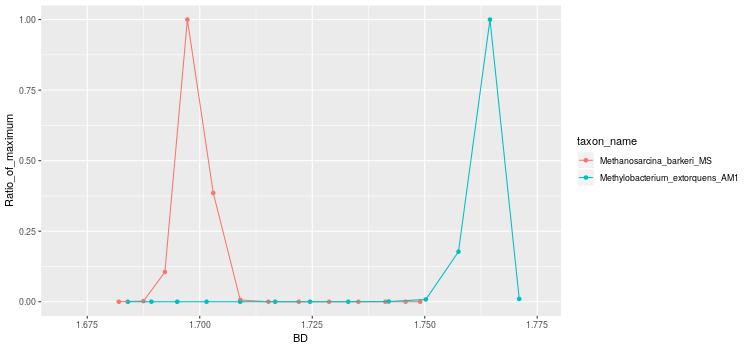

In [39]:
%%R -h 350 -w 750

SIPSim2.plot = ggplot(data=metaSIPSim.df, aes(x=BD, y=Ratio_of_maximum, color=taxon_name)) +
    geom_point() +
    geom_line() +
    xlim(1.67, 1.775)
SIPSim2.plot

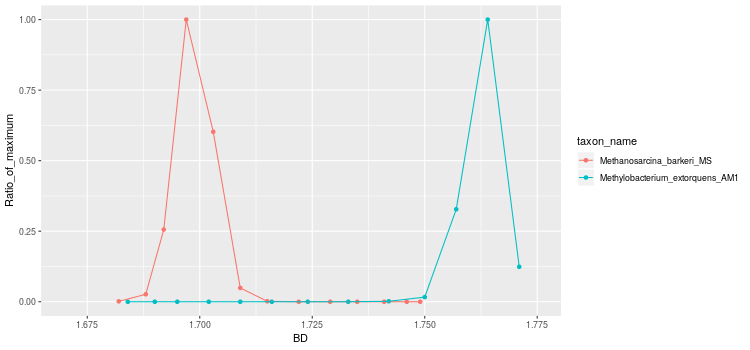

In [40]:
%%R -h 350 -w 750

SIPSim.plot = ggplot(data=SIPSim.df, aes(x=BD, y=Ratio_of_maximum, color=taxon_name)) +
    geom_point() +
    geom_line() +
    xlim(1.67, 1.775)
SIPSim.plot

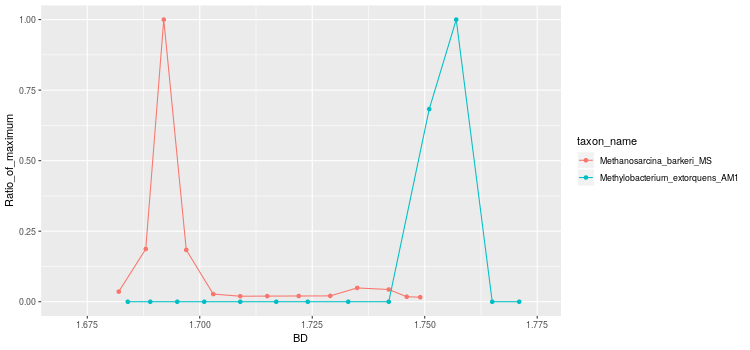

In [41]:
%%R -h 350 -w 750
real.plot = ggplot(data=real.df, aes(x=BD, y=Ratio_of_maximum, color=taxon_name)) +
    geom_point() +
    geom_line() +
    xlim(1.67, 1.775)

real.plot

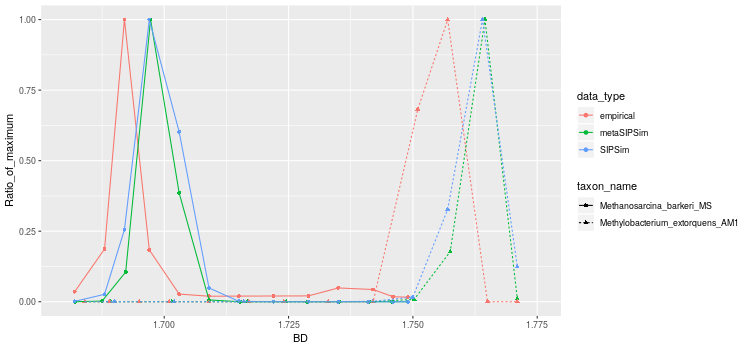

In [42]:
%%R -h 350 -w 750
full.plot = ggplot(data=full.df, aes(x=BD, y=Ratio_of_maximum, color=data_type)) +
    geom_point(aes(shape=taxon_name)) +
    geom_line(aes(linetype=taxon_name)) +
    xlim(1.68, 1.775)

full.plot